# Mediation analysis with DoWhy: Direct and Indirect Effects

In [1]:
import numpy as np
import pandas as pd
    
from dowhy import CausalModel
import dowhy.datasets

# Warnings and logging
import warnings
warnings.filterwarnings('ignore')

## Creating a dataset

In [2]:
# Creating a dataset with a single confounder and a single mediator (num_frontdoor_variables)
data = dowhy.datasets.linear_dataset(10, num_common_causes=1, num_samples=10000,
                                     num_instruments=0, num_effect_modifiers=0,
                                     num_treatments=1,
                                     num_frontdoor_variables=1,
                                     treatment_is_binary=False,
                                    outcome_is_binary=False)
df = data['df']
print(df.head())

        FD0        W0        v0         y
0  1.034453  0.654626  2.971381  4.613134
1 -0.273332  0.062294 -0.516102 -0.324941
2  0.893013  0.381559  2.666668  3.299316
3 -0.319602  0.299824  1.300627  0.482658
4 -0.406848 -0.526452 -3.542526 -2.844588


## Step 1: Modeling the causal mechanism
We create a dataset following a causal graph based on the frontdoor criterion. That is, there is no direct effect of the treatment on outcome; all effect is mediated through the frontdoor variable FD0.

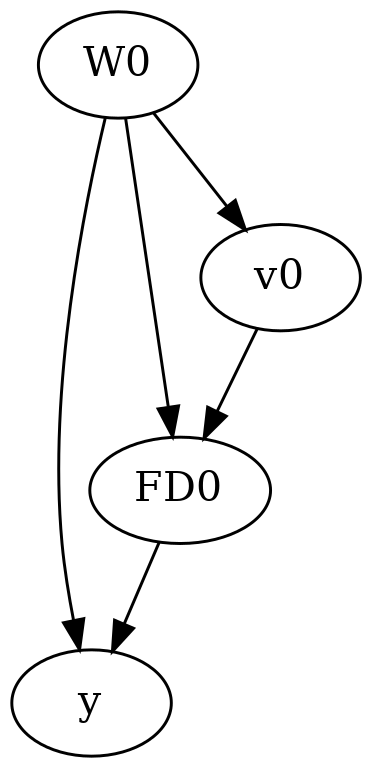

In [3]:
model = CausalModel(df,
                    data["treatment_name"],data["outcome_name"],
                    data["gml_graph"],
                   missing_nodes_as_confounders=True)

model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Step 2: Identifying the natural direct and indirect effects
We use the `estimand_type` argument to specify that the target estimand should be for a **natural direct effect** or the **natural indirect effect**. For definitions, see [Interpretation and Identification of Causal Mediation](https://ftp.cs.ucla.edu/pub/stat_ser/r389-imai-etal-commentary-r421-reprint.pdf) by Judea Pearl.

**Natural direct effect**: Effect due to the path v0->y

**Natural indirect effect**: Effect due to the path v0->FD0->y (mediated by FD0).

In [4]:
# Natural direct effect (nde)
identified_estimand_nde = model.identify_effect(estimand_type="nonparametric-nde", 
                                            proceed_when_unidentifiable=True)
print(identified_estimand_nde)

Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡  d         ⎤
E⎢─────(y|FD0)⎥
 ⎣d[v₀]       ⎦
Estimand assumption 1, Mediation: FD0 intercepts (blocks) all directed paths from v0 to y except the path {v0}→{y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{v0} and U→{FD0} then P(FD0|v0,U) = P(FD0|v0)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FD0} and U→y then P(y|FD0, v0, U) = P(y|FD0, v0)



In [5]:
# Natural indirect effect (nie)
identified_estimand_nie = model.identify_effect(estimand_type="nonparametric-nie", 
                                            proceed_when_unidentifiable=True)
print(identified_estimand_nie)

Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡  d         d         ⎤
E⎢──────(y)⋅─────([FD₀])⎥
 ⎣d[FD₀]    d[v₀]       ⎦
Estimand assumption 1, Mediation: FD0 intercepts (blocks) all directed paths from v0 to y except the path {v0}→{y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{v0} and U→{FD0} then P(FD0|v0,U) = P(FD0|v0)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FD0} and U→y then P(y|FD0, v0, U) = P(y|FD0, v0)



## Step 3: Estimation of the effect
Currently only two stage linear regression is supported for estimation. We plan to add a non-parametric Monte Carlo method soon as described in [Imai, Keele and Yamamoto (2010)](https://projecteuclid.org/euclid.ss/1280841733).

#### Natural Indirect Effect
The estimator converts the mediation effect estimation to a series of backdoor effect estimations. 
1. The first-stage model estimates the effect from treatment (v0) to the mediator (FD0).
2. The second-stage model estimates the effect from mediator (FD0) to the outcome (Y).

In [6]:
import dowhy.causal_estimators.linear_regression_estimator
causal_estimate_nie = model.estimate_effect(identified_estimand_nie,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                       )
print(causal_estimate_nie)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡  d         d         ⎤
E⎢──────(y)⋅─────([FD₀])⎥
 ⎣d[FD₀]    d[v₀]       ⎦
Estimand assumption 1, Mediation: FD0 intercepts (blocks) all directed paths from v0 to y except the path {v0}→{y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{v0} and U→{FD0} then P(FD0|v0,U) = P(FD0|v0)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FD0} and U→y then P(y|FD0, v0, U) = P(y|FD0, v0)

## Realized estimand
(b: FD0~v0+W0)*(b: y~FD0+W0)
Target units: ate

## Estimate
Mean value: 0.7061424673479606



Note that the value equals the true value of the natural indirect effect (up to random noise). 

In [7]:
print(causal_estimate_nie.value, data["ate"])

0.7061424673479606 0.7173536820369499


The parameter is called `ate` because in the simulated dataset, the direct effect is set to be zero. 

#### Natural Direct Effect
Now let us check whether the direct effect estimator returns the (correct) estimate of zero.

In [8]:
causal_estimate_nde = model.estimate_effect(identified_estimand_nde,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                       )
print(causal_estimate_nde)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
Estimand expression:
 ⎡  d         ⎤
E⎢─────(y|FD0)⎥
 ⎣d[v₀]       ⎦
Estimand assumption 1, Mediation: FD0 intercepts (blocks) all directed paths from v0 to y except the path {v0}→{y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{v0} and U→{FD0} then P(FD0|v0,U) = P(FD0|v0)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FD0} and U→y then P(y|FD0, v0, U) = P(y|FD0, v0)

## Realized estimand
(b: y~v0+W0) - ((b: FD0~v0+W0)*(b: y~FD0+W0))
Target units: ate

## Estimate
Mean value: -3.0154201615006926e-05



## Step 4: Refutations
TODO